<a href="https://colab.research.google.com/github/lartmann/deepfake_detection_project/blob/main/Nonverbal_bevaviour_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟡 🟢 Imports

🟡: run if you want to process the videos

🟢: run if you already have the numpy arrays saved on google drive

🔴: old stuff

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
#from tensorflow_docs.vis import embed
import numpy as np
import pandas as pd
import cv2
import os

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🟡 Load kaggle Dataset 
upload kaggle.json file with credentials to main folder

In [ ]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
! cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/ #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

In [ ]:
#!kaggle competitions download -c 'Deepfake-Detection-Challenge' --force

In [ ]:
!kaggle datasets download -d sorokin/faceforensics

100% 8.38G/8.40G [01:08<00:00, 124MB/s]
100% 8.40G/8.40G [01:08<00:00, 132MB/s]


In [ ]:
import os
#!unzip Deepfake-Detection-Challenge.zip -d Deepfake-Detection-Challenge
os.chdir('/content')
!unzip faceforensics.zip -d faceforensics

Streaming output truncated to the last 5000 lines.
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/000_003.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/001_870.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/002_006.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/003_000.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/004_982.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/005_010.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/006_002.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/007_132.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/008_990.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/009_027.mp4  
  inflating: faceforensics/manipulated_sequences/Deepfakes/c23/videos/010_005.mp4  
  inflating: faceforensic

# 🔴 Preprocessing

In [ ]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
input_size = 192
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()


In [ ]:
def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

In [ ]:
def main_visualize(image):
  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

  # Run model inference.
  keypoints_with_scores = movenet(input_image)

  # Visualize the predictions with image.
  #display_image = tf.expand_dims(image, axis=0)
  #display_image = tf.cast(tf.image.resize_with_pad(
      #display_image, 1280, 1280), dtype=tf.int32)
  #output_overlay = draw_prediction_on_image(
  #    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

  #plt.figure(figsize=(5, 5))
  #plt.imshow(output_overlay)
  #_ = plt.axis('off')
  return keypoints_with_scores

In [ ]:
# 1. video

video = cv2.VideoCapture('test1.mp4')
def video_to_images(video):
  success,image = video.read()
  #print(success, image)
  count = 0
  out = []
  while success:
    out.append(image.imread())
    #cv2.imwrite("output/frame%d.jpg" % count, out)     # save frame as JPEG file      
    success,image = video.read()
    print('Read a new frame: ', success)
    count += 1
  return out

## Facial recognition with MediaPipe

In [ ]:
#out = tf.expand_dims(out, axis=0)
#out2 = tf.expand_dims(out2, axis=0)
#con = tf.squeeze(tf.concat([out,out2], axis=0))
#tf.stack([con, [1,0]], axis=1)

In [ ]:
# 2. video
vidcap = cv2.VideoCapture('test2.mp4')
success,image = vidcap.read()
count = 0
#out2 = main_visualize(image)
while success:
  #out2 = tf.concat([out2, main_visualize(image)], axis=0)
  #cv2.imwrite("output/frame%d.jpg" % count, out)     # save frame as JPEG file      
  #success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

## Functions 

In [ ]:
!pip install mediapipe

In [ ]:
# video to images function

def video_to_images(video):
  ''' 
  extracts the images of a video and saves them in an dictionary which is returned
  '''
  #reads one frame from video and moves current position of the video to next frame
  success,image = video.read() 
  count = 0
  out = {}
  while success:
    # saves the Frame in a dictionary with the frameNumber as key
    out.update({"frame%d" % count: image})  
    # read next frame  
    success,image = video.read()
    count += 1
  return out

In [ ]:
# show image function

import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np

DESIRED_HEIGHT = 480
DESIRED_WIDTH = 480
def resize_and_show(image):
  """
  shows the image for visualisation purposes
  """
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

In [ ]:
def extract_landmarks(images):
  """
  uses mediapip NN to extract the facial landmarks form an array of images
  returns an array with the MeadiaPipe output for each Image
  """
  output = []
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      refine_landmarks=True,
      max_num_faces=2,
      min_detection_confidence=0.5) as face_mesh:
    # loop through all images in the input array
    for name, image in images.items():
      # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      output.append(results)
  return output

In [ ]:
def draw_landmarks_on_img(images):
  """
  extract the landmarks of an array of images and visualizes how MediaPipe estimated the face mesh
  returns an array with the MeadiaPipe output for each Image
  """
  output = []
  # Run MediaPipe Face Mesh.
  with mp_face_mesh.FaceMesh(
      static_image_mode=True,
      refine_landmarks=True,
      max_num_faces=2,
      min_detection_confidence=0.5) as face_mesh:
    for name, image in images.items():
      # Convert the BGR image to RGB and process it with MediaPipe Face Mesh.
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      output.append(results)

      # Draw face landmarks of each face.
      print(f'Face landmarks of {name}:')
      if not results.multi_face_landmarks:
        continue
      annotated_image = image.copy()
      for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
      resize_and_show(annotated_image)
  return output

In [ ]:
import pandas as pd

def landmarks_to_df(results):
  """
  transforms the MediaPipe output of one frame into a dataframe that consists of ONE row and 3 columns for each coordinate
  returns the new df
  """
  d = {}
  for i in range(478):
    # catches TypeError in case the Mediapipe output of a coordinate is NaN (couldn't be idetified for the frame)
    try:
      d.update({
          # wites columns x,y,z for each coordinate
          'x_'+str(i): results.multi_face_landmarks[0].landmark[i].x,
          'y_'+str(i): results.multi_face_landmarks[0].landmark[i].y,
          'z_'+str(i): results.multi_face_landmarks[0].landmark[i].z,
      })
    except TypeError:
      # skips this coordinate because it is not usable
      pass
  return pd.DataFrame(d, index=range(1))

In [ ]:
def join_image_dfs(input_dfs):
  """
  joins the dfs of every single frame and returns one df for the dfs in the input array (frames of one video)
  """
  # create first df that the others can be appended to
  video_df = landmarks_to_df(input_dfs[0])
  count = 0
  for result in input_dfs:
    # in case the face coudn't be detected in previous images
    if len(video_df.columns) > 5:
      # only append if the input_dfs is not empty
      #if len(video_df) > 5:
      video_df = video_df.append(landmarks_to_df(result))
      #print('append')
    else: 
      video_df = landmarks_to_df(result)
      #print('empty')
    count += 1
  return video_df

#### Transform DataFrame
Group coordinates together into new dimension

In [ ]:
def transform_dfs(dfs_list):
  dfs_transformed_list = []
  # groupe coordinates together to get a tuple of 3 for each coordinate
  for df in dfs_list:
    dfs_transformed = pd.DataFrame()
    for i in range(478):
      try:
        dfs_transformed['c_' + str(i)] = list(zip(df['x_' + str(i)], df['y_' + str(i)], df['z_' + str(i)]))
      except KeyError:
        print(i)
    dfs_transformed_list.append(dfs_transformed)
  return dfs_transformed_list


### load MediaPipe

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
mp_face_mesh = mp.solutions.face_mesh

# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

### MAIN

#### Deep Fake Detection Challengen dataset

In [ ]:
import json
import os

# change Working directory to the video folder
os.chdir('Deepfake-Detection-Challenge/train_sample_videos')

In [ ]:
# load labels from json file
with open('metadata.json','r') as j:
     labels = json.loads(j.read())
labels

In [ ]:
count = 0
# loop throug all the files in a 
for video in os.listdir():
  if video.endswith('.mp4'):
    v = cv2.VideoCapture(video)
    imgs = video_to_images(v)
    o = extract_landmarks(imgs)
    # create first df 
    if count == 0:
      dfs = join_image_dfs(o)
      dfs['label'] = labels[video]['label']
      dfs['VideoId'] = video
      count += 1
    # append to previous df
    else:
      df = join_image_dfs(o)
      df['label'] = labels[video]['label']
      df['VideoId'] = video
      dfs = pd.concat([dfs, df])
      count += 1
  #if count > 5:
   # break
  print('done ' + str(count) )

KeyboardInterrupt: ignored

In [ ]:
dfs.to_csv('out1.csv')
!cp out1.csv "/content/drive/My Drive/"

In [ ]:
dfs_nona = dfs.dropna()
dfs_nona = dfs_nona.reset_index(drop=True)
dfs_nona.to_csv('out_nona.csv')
!cp out_nona.csv "/content/drive/My Drive/"

In [ ]:
dfs_nona

##### Test

In [ ]:
v_fake = cv2.VideoCapture('etmcruaihe.mp4')
v_original = cv2.VideoCapture('afoovlsmtx.mp4')

imgs_fake = video_to_images(v_fake)
imgs_original = video_to_images(v_original)


In [ ]:
#output = draw_landmarks_on_img(imgs)
output_fake = extract_landmarks(imgs_fake)
output_original = extract_landmarks(imgs_original)


In [ ]:
video_df_fake = join_image_dfs(output_fake)
video_df_original = join_image_dfs(output_original)

In [ ]:
#video_df.reset_index(drop=True)

In [ ]:
# compare fake and real
#video_df_original.compare(video_df_fake)
#video_df_fake

df_con = pd.concat([video_df_original, video_df_fake], keys=['original', 'fake'],names=['Series name', 'Row ID'])
df_con.groupby('Series name').mean()

,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_474,x_475,y_475,z_475,x_476,y_476,z_476,x_477,y_477,z_477
Series name,,,,,,,,,,,,,,,,,,,,,
original,0.401152,0.471183,-0.037070,0.402029,0.454824,-0.050685,0.403437,0.462373,-0.032038,0.393824,...,0.018203,0.448639,0.424146,0.018203,0.439120,0.428233,0.018203,0.448677,0.432417,0.018203
fake,0.402926,0.471003,-0.038333,0.399389,0.453024,-0.051811,0.401056,0.460871,-0.033252,0.391555,...,0.017947,0.448014,0.423959,0.017947,0.438819,0.428123,0.017947,0.447709,0.432381,0.017947


#### Face Forensic Dataset

##### Get Fake Data

In [ ]:
import os
os.chdir('/content/faceforensics/manipulated_sequences/Face2Face/c23/videos')


In [ ]:
count = 0
dfs_list_fake = []
# loop throug all the files in a 
for video in os.listdir():
  if video.endswith('.mp4'):
    v = cv2.VideoCapture(video)
    imgs = video_to_images(v)
    o = extract_landmarks(imgs)
    df = join_image_dfs(o)
    df['VideoId'] = video
    #dfs = pd.concat([dfs, df])
    dfs_list_fake.append(df)
    count += 1
  if count > 50:
    break
  print('done ' + str(count) )

https://www.tensorflow.org/guide/ragged_tensor

In [ ]:
dfs_transformed_list_fake = transform_dfs(dfs_list_fake)

# ragged tensro shape: (num_videos, num_frames, num_landmarks(478), num_cordinates(3))
array_fake = [x.to_numpy() for x in dfs_transformed_list_fake]
#data_fake = tf.ragged.constant(array_fake, dtype=float)
#data_fake.bounding_shape()

In [ ]:
#np.array(array_fake)
np.savez_compressed('/content/drive/MyDrive/data_face2face_50.npz', fake = np.array(array_fake))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:


#print(array_fake.shape)
np.load('/content/drive/MyDrive/data_face2face_100.npz', allow_pickle=True)['fake']

##### Get Original Data

In [ ]:
import os
os.chdir('/content/faceforensics/original_sequences/youtube/c23/videos')

In [ ]:
count = 0
dfs_list_original = []
# loop throug all the files in a 
for video in os.listdir():
  if video.endswith('.mp4'):
    v = cv2.VideoCapture(video)
    imgs = video_to_images(v)
    o = extract_landmarks(imgs)
    df = join_image_dfs(o)
    df['VideoId'] = video
    #dfs = pd.concat([dfs, df])
    dfs_list_original.append(df)
    count += 1
  if count > 50:
    break
  print('done ' + str(count) )

In [ ]:
dfs_transformed_list_original = transform_dfs(dfs_list_original)
array_original = [x.to_numpy() for x in dfs_transformed_list_original]
# ragged tensor shape: (num_videos, num_frames, num_landmarks(478), num_cordinates(3))
#data_original = tf.ragged.constant([x.to_numpy() for x in dfs_transformed_list_original], dtype='float32' )
#data_original.bounding_shape()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


In [ ]:
np.savez_compressed('/content/drive/MyDrive/data_face2face_original_50.npz', original = np.array(array_original))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


##### Combine Fake and Original

In [ ]:
data_fake = tf.ragged.constant(np.load('/content/drive/MyDrive/data_face2face_50.npz', allow_pickle=True)['fake'], dtype='float32' )

In [ ]:
data_original = tf.ragged.constant(np.load('/content/drive/MyDrive/data_face2face_original_50.npz', allow_pickle=True)['original'], dtype='float32' )

In [ ]:
data = tf.concat([data_fake, data_original], axis = 0)
data_fake = []
data_original = []

In [ ]:
y = tf.constant([0]*51 + [1]*51, dtype='int32')

In [ ]:
data = data.to_sparse()
data = tf.sparse.to_dense(data)

In [ ]:
data.shape

TensorShape([102, 1497, 478, 3])

# Training

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, shuffle=True, random_state=42, test_size=0.2)

In [ ]:
tf.random.set_seed(42)

# ragged_input = tf.keras.layers.Input(shape=[], dtype=tf.float32, ragged=True)

model_4 = tf.keras.Sequential([
	tf.keras.layers.Input(shape=[1497, 478, 3], dtype='float32'),
	tf.keras.layers.Dense(10, activation = "relu"),
	tf.keras.layers.Dense(1)
])

model_4.compile(loss = "binary_crossentropy",
				optimizer = tf.keras.optimizers.Adam(),
				metrics = ["accuracy"])

history = model_4.fit(tf.sparse.to_dense(data_sparse), labels, epochs = 20)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = Sequential([
  Input(shape=[1497, 478, 3], dtype=tf.float32, ragged=False),
  Conv2D(filters=10, 
         kernel_size=3, # can also be (3, 3)
         strides=1,
         padding="valid",
         activation="relu"),
         #input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
            padding="valid"), # padding can also be 'same'
  Conv2D(10, 3, activation="relu"),
  Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  MaxPool2D(2),
  Flatten(),
  Dense(10, activation="relu"), # binary activation output
  Dense(100, activation="relu"),
  Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(data,
                        y,
                        epochs=5)

Epoch 1/5
7/7 [==============================] - 184s 25s/step - loss: nan - accuracy: 0.5050
Epoch 2/5
7/7 [==============================] - 170s 24s/step - loss: nan - accuracy: 0.5000
Epoch 3/5
7/7 [==============================] - 169s 24s/step - loss: nan - accuracy: 0.5000
Epoch 4/5
7/7 [==============================] - 175s 25s/step - loss: nan - accuracy: 0.5000
Epoch 5/5
7/7 [==============================] - 168s 24s/step - loss: nan - accuracy: 0.5000


# Computer Vision

## Preprocessing 2

Goal Shape: `(num_batches, num_max_frame, width, height, channel)`

**Steps:**

1. Video to Image-Array
2. extract faces
3. crop to face
4. save as nparray


**Reshape data:**
5. Pad images (that all have the same dimensions)
  - find max height and width for ALL faces
6. split videos into batches (with same number of frames)







### 🟡 Functions and helpers

In [ ]:
!pip install mediapipe

In [ ]:

def video_to_images_array(video):
  ''' 
  extracts the images of a video and saves them in an dictionary which is returned
  '''
  #reads one frame from video and moves current position of the video to next frame
  success,image = video.read() 
  count = 0
  out = []
  while success:
    # saves the Frame in a dictionary with the frameNumber as key
    out.append(image) 
    # read next frame  
    success,image = video.read()
    count += 1
  return out

In [ ]:
import mediapipe as mp

def get_face_box(IMAGE_FILES):
  mp_face_detection = mp.solutions.face_detection
  mp_drawing = mp.solutions.drawing_utils

  face_boxes = []

  # For static images:

  with mp_face_detection.FaceDetection(
      model_selection=1, min_detection_confidence=0.5) as face_detection:
    for idx, file in enumerate(IMAGE_FILES):
      image = file
      # Convert the BGR image to RGB and process it with MediaPipe Face Detection.
      results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      face_boxes.append(results.detections)

  return face_boxes


In [ ]:
from PIL import Image

def process_images(imgs, max_h, max_w):
  '''
  Preprocess image including: cropping to face, padding/resize to right shape, and batching
  '''
  
  faces = np.zeros((1, max_h, max_w, 3), dtype=np.float16)
  batch_result = np.zeros((1, 50, max_h, max_w, 3))
  
  # extract face box
  face_boxes = get_face_box(imgs)
  num_no_face = 0

  # crop image to face
  for frame, image in zip(face_boxes, imgs):
    h,w,c = image.shape
    try:
      left = int(frame[0].location_data.relative_bounding_box.xmin*w)
      top = int(frame[0].location_data.relative_bounding_box.ymin*h)
      right = int(frame[0].location_data.relative_bounding_box.width*w + left)
      bottom = int(frame[0].location_data.relative_bounding_box.height*h + top)
    
      frame = frame
      face = Image.fromarray(image).crop((left, top, right, bottom))
      face_np = np.asarray(face, dtype=np.float16)/255.0
      
      # get padding if image is too small
      if face_np.shape[0] < max_h: 
          face_np = np.pad(face_np, ((0,max_h - face_np.shape[0]),(0,0),(0,0)))
      if face_np.shape[1] < max_w:
        face_np = np.pad(face_np, ((0,0),(0,max_w - face_np.shape[1]),(0,0)))
      #if face_np.shape != (max_h,max_w,3):
      # print(face_np.shape)
      
      # resize is image is too big
      if face_np.shape[0] > max_h or face_np.shape[1] > max_w:
        face_np = np.resize(face_np, (max_h,max_w,3))

      faces = np.vstack([faces, np.float16(np.expand_dims(face_np, axis=0))])
    except TypeError:
      num_no_face += 1
  print(f'could not detect the face in {num_no_face} frames')
  # get batches of size 50
  num_batches = int(len(imgs)/50)
  for i in range(num_batches):
    batch = faces[i*50:(i+1)*50]
    if len(batch) == 50:
      batch_result = np.vstack([batch_result, np.expand_dims(batch, axis = 0)])

  return np.float16(batch_result)

In [ ]:
def find_max(videos):
  max_h = 0
  max_w = 0
  for v in videos:
    if v.shape[0] > max_h:
      max_h = v.shape[0]
    if v.shape[1] > max_w:
      max_w = v.shape[1]
    '''
    for f in v:
      if len(f) > max_h:
        max_h = len(f)
      if len(f[0]) > max_w:
        max_w = len(f[0])
      '''
  return (max_h, max_w)


In [ ]:
# fill up the empty frames
def get_padding(videos, max_h, max_w):
  for n, v in enumerate(videos):
    for i, f in enumerate(v):
      if f.shape[0] < max_h:
        videos[n][i] = np.pad(f, ((0,max_h - f.shape[0]),(0,0),(0,0)))
        f = np.pad(f, ((0,max_h - f.shape[0]),(0,0),(0,0)))
      
      if len(f[0]) < max_w:
        videos[n][i] = np.pad(f, ((0,0),(0,max_w - f.shape[1]),(0,0)))
      if videos[n][i].shape != (310,310,3):
        print(videos[n][i].shape)
  return videos

      

In [ ]:
#shape: (num_vid, num_frames, width, height, channels)
#shape: (num_batches, num_frames, max_h, max_w, channels) → (n, 50, 310, 310, 3)

def split_in_batches(results):
  batch_result = np.array([], dtype=np.float16)
  for v in results:
    num_batches = int(len(v)/50)

    for i in range(num_batches):
      batch = v[i*50:(i+1)*50]
      if len(batch) == 50:
        batch_result = np.append(batch_result, batch)
        batch_result.append(batch)
    
  return batch_result

### 🟡 MAIN Preprocessing

#### Process F2F Videos
Save them to google Drive

In [ ]:
# move to directory with f2f videos
os.chdir('/content/faceforensics/manipulated_sequences/Face2Face/c23/videos')


f2f_path = '/content/drive/MyDrive/nvb/F2F'
count = 0
# loop throug all the files in a 
for video in os.listdir():
  count += 1
  if video.endswith('.mp4') and f'{video}.npz' not in os.listdir(f2f_path):
    #count += 1
    v = cv2.VideoCapture(video)
    imgs = video_to_images_array(v)
    faces = process_images(imgs, 300,300)
    print(faces.shape)
    print(faces.dtype)
    # save imgs as np array
    np.savez_compressed(f'{f2f_path}/{video}.npz', data = faces, labels = [1]*len(faces))
    #np.savez_compressed(f'{f2f_path}/{video}.npz', )
  print('done ' + str(count) )
  #if count >= 3:
    #break

In [ ]:
for f in os.listdir(f2f_path):
  if f.endswith('.npz'):

    print(f)
    data = np.load(f'{f2f_path}/{f}')
    np.savez_compressed(f'{f2f_path}/{f}_with_labels.npz', data = data, labels = [1]*len(data))

####  Process original Videos
Save numpy to google Drive

In [ ]:
os.chdir('/content/faceforensics/original_sequences/youtube/c23/videos')

count = 0
original_path = '/content/drive/MyDrive/nvb/original'
# loop throug all the files in a 
for video in os.listdir():
  count += 1
  if video.endswith('.mp4') and f'{video}.npz' not in os.listdir(original_path):
    #count += 1
    v = cv2.VideoCapture(video)
    imgs = video_to_images_array(v)
    faces = process_images(imgs, 300,300)
    print(faces.shape)
    print(faces.dtype)
    # save imgs as np array
    np.savez_compressed(f'{original_path}/{video}.npz', data = faces)
  print('done ' + str(count) )
  #if count >= 3:
  #  break

### 🟢 F2F: Load numpy arrays and combine to tensor

In [ ]:
# Set Hyperparameters
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 42
NUMBER_VIDEOS = 5

In [ ]:
f2f_path = '/content/drive/MyDrive/nvb/F2F'

count = 0
for np_file in os.listdir(f2f_path):
  if np_file.endswith('mp4.npz'):
    count += 1
    if count == 1:
      file_np = np.load(f'{f2f_path}/{np_file}', allow_pickle=True)['data'] # Load file
      file_tensor = tf.convert_to_tensor(file_np) # convert np to tensor
      labels_tensor = tf.expand_dims(tf.convert_to_tensor(np.array([0] * len(file_np))), axis=1) # create labels
      f2f_data = tf.data.Dataset.from_tensor_slices((file_np, labels_tensor)) # create dataset from values and labels
      train_size_fake = len(file_np) # set train size
    elif count <= NUMBER_VIDEOS:
      file_np = np.load(f'{f2f_path}/{np_file}', allow_pickle=True)['data'] # Load file
      file_tensor = tf.convert_to_tensor(file_np) # convert np to tensor
      labels_tensor = tf.expand_dims(tf.convert_to_tensor(np.array([0] * len(file_np))), axis=1) # create labels
      current = tf.data.Dataset.from_tensor_slices((file_np, labels_tensor)) # create dataset from values and labels
      f2f_data = f2f_data.concatenate(current) # append current dataset to the rest
      if count <= NUMBER_VIDEOS * 0.8:
        # count the size of the train dataset (80% of videos)
        train_size_fake = train_size_fake + len(file_np)
    else:
      break
  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 🟢 original: load numpy arrays and combine to tensor

In [ ]:
original_path = '/content/drive/MyDrive/nvb/original'
count = 0
for np_file in os.listdir(original_path):
  count += 1
  if count == 1:
    file_np = np.load(f'{original_path}/{np_file}', allow_pickle=True)['data'] # Load file
    file_tensor = tf.convert_to_tensor(file_np) # convert np to tensor
    labels_tensor = tf.expand_dims(tf.convert_to_tensor(np.array([1] * len(file_np))), axis=1) # create labels
    original_data = tf.data.Dataset.from_tensor_slices((file_np, labels_tensor)) # create dataset
    train_size_or = len(file_np) # initialize train size
  elif count <= NUMBER_VIDEOS:
    file_np = np.load(f'{original_path}/{np_file}', allow_pickle=True)['data'] # Load file
    file_tensor = tf.convert_to_tensor(file_np) # convert np to tensor
    labels_tensor = tf.expand_dims(tf.convert_to_tensor(np.array([1] * len(file_np))), axis=1) # create labels
    current = tf.data.Dataset.from_tensor_slices((file_np, labels_tensor)) # create dataset of current tensor
    original_data = original_data.concatenate(current) # append current dataset to existing 
    if count <= NUMBER_VIDEOS * 0.8:
        train_size_or = train_size_or + len(file_np) # count train size
  else:
    break

In [ ]:
# split data into test and train 
# makes sure that all clips of one video are in either train OR test

train_data_f = f2f_data.take(train_size_fake)
test_data_f = f2f_data.skip(train_size_fake)

train_data_o = original_data.take(train_size_or)
test_data_o = original_data.skip(train_size_or)

In [ ]:
train_data = train_data_f.concatenate(train_data_o).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_data = test_data_f.concatenate(test_data_o).shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Training

## 1. Model 
basic CNN Model

In [ ]:
from sklearn.utils import validation
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPool3D, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

In [ ]:
from sklearn.utils import validation
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

tf.random.set_seed(42)

model_1 = Sequential([
  Input(shape=[50, 300, 300, 3], dtype=tf.float16),
  Flatten(input_shape = (50,300,300,3)),
  Dense(10, activation="relu"), # binary activation output
  Dense(100, activation="relu"),
  Dense(1, activation="sigmoid")
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        validation_data = test_data,
                        #batch_size=32,
                        epochs=10)
                        #validation_split=0.2
                        


Epoch 1/10
3/3 [==============================] - 6s 1s/step - loss: 38.7512 - accuracy: 0.4074 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 2/10
3/3 [==============================] - 2s 675ms/step - loss: 15.1874 - accuracy: 0.8519 - val_loss: 121.0055 - val_accuracy: 0.3095
Epoch 3/10
3/3 [==============================] - 2s 705ms/step - loss: 30.9626 - accuracy: 0.7778 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 4/10
3/3 [==============================] - 2s 673ms/step - loss: 8.3279 - accuracy: 0.9383 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 5/10
3/3 [==============================] - 2s 675ms/step - loss: 3.4543 - accuracy: 0.9259 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 6/10
3/3 [==============================] - 2s 718ms/step - loss: 0.0685 - accuracy: 0.9506 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 7/10
3/3 [==============================] - 2s 680ms/step - loss: 0.0685 - accuracy: 0.9506 - val_loss: 0.0330 - val_accuracy: 0.9762
Epoch 8/10
3/3 [==

In [ ]:
model_1 = 0


In [ ]:
model_2 = Sequential([
  Input(shape=[50, 300, 300, 3], dtype=tf.float16),
  Conv3D(10,(3,3,3), activation="relu", input_shape=(50, 300, 300, 3)),
  #Conv3D(32,(3,3,3), activation="relu"),
  MaxPool3D(pool_size=2,padding="valid"),
  #Conv3D(64,(3,3,3), activation="relu"),
  #Conv3D(128,(3,3,3), activation="relu"),
  #MaxPool3D(5)
  Flatten(input_shape = (50,300,300,3)),
  #Dense(10, activation="relu"), # binary activation output
  #Dense(100, activation="relu"),
  Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        validation_data = test_data,
                        #batch_size=32,
                        epochs=10)
                        #validation_split=0.2

Epoch 1/10


ResourceExhaustedError: ignored

In [ ]:
def plot_loss_curves(history):
  """
  Plots the loss curve and accuracy for a given model
  Args:
    history: the history object returned by the fit method of a Keras model
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(loss))

  # plot loss
  plt.plot(epochs, loss, label="Training loss")
  plt.plot(epochs, val_loss, label="Validation loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  #plt.ylabel("")
  plt.legend()
  
  # plot accuracy
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label="Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  #plt.ylabel("")
  plt.legend()
  
  plt.show()

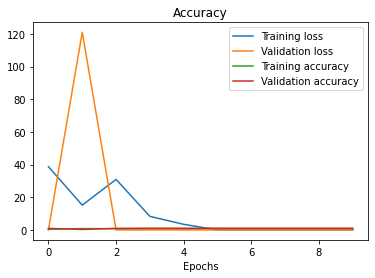

In [ ]:
plot_loss_curves(history_1)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv1D, Conv1DTranspose, MaxPooling1D, UpSampling1D
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError as MeanSquaredErrorMetric


def build_convolutional_ae(input_dim):
    """
    Build convolutional autoencoder
    Args:
        input_dim: input dimensions
        latent_dim: bottleneck dimensions, latent space
    """
    
    encoder = Sequential([
        #Reshape(
            #target_shape=(-1, 1)
        #),
        Conv1D(
            filters=16, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
        #MaxPooling1D(
         #   pool_size=2
        #),
        Conv1D(
            filters=32, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
        #MaxPooling1D(
         #   pool_size=2
        #),
        Conv1D(
            filters=64, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
        #MaxPooling1D(
            #pool_size=2
        #),
        Flatten(),
        Dense(
            units = 1,
            activation='relu',
            activity_regularizer=L1(
                l1=0.001
            )
        )
    ])

    decoder = Sequential([
        Dense(
            units=input_dim // 2**3 * 64
        ),
        Reshape(
            target_shape=(input_dim // 2**3, 64)
        ),
        Conv1DTranspose(
            filters=64, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
        #UpSampling1D(
         #   size=2
        #),
        Conv1DTranspose(
            filters=32, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
        #UpSampling1D(
         #   size=2
        #),
        Conv1DTranspose(
            filters=16, 
            kernel_size=3, 
            padding='same', 
            activation='relu'
        ),
       # UpSampling1D(
        #    size=2
        #),
        Conv1D(
            filters=1, 
            kernel_size=3, 
            padding='same', 
            activation='sigmoid'
        )
    ])

    convolutional_ae = Sequential([encoder, decoder])

    convolutional_ae.compile(
        optimizer=Adam(
            learning_rate=0.001
        ),
        loss=MeanSquaredError(),
        metrics=[
            MeanSquaredErrorMetric(name='MSE')
        ]
    )

    return convolutional_ae

In [ ]:
model_2 = build_convolutional_ae(3)

In [ ]:
history_2 = model_2.fit(train_data,
                        #batch_size=32,
                        epochs=5)
                        #validation_split=0.2

Epoch 1/5
